In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import SVHN
from sklearn.model_selection import train_test_split

from src.data_utils import (
    get_train_weak_transform,
    get_train_strong_transform,
    get_test_transform,
    get_unlabeled_and_labeled_indices,
)

In [14]:
class SSDADatasetWithLabel(Dataset):
    def __init__(self, imgs, labels, transform):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.imgs[index], self.labels[index]
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))
        if self.transform:
            img = self.transform(img)
        return img, int(label)

    def __len__(self):
        return len(self.imgs)


class SSDADatasetWithoutLabel(Dataset):
    def __init__(self, imgs, weak_transform, strong_transform):
        self.imgs = imgs
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __getitem__(self, index):
        img = self.imgs[index]
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))
        weak_x = self.weak_transform(img)
        strong_x = self.strong_transform(img)
        return weak_x, strong_x

    def __len__(self):
        return len(self.imgs)

In [ ]:
loaded_train_svhm = SVHN(
        root='./svhm/',
        split='train',
        download=True,
)
X_train_loaded, y_train_loaded = loaded_train_svhm.data, loaded_train_svhm.labels
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_loaded,
    y_train_loaded,
    shuffle=True,
    stratify=y_train_loaded,
    random_state=2024
)
weak_trans = get_train_weak_transform()
strong_trans = get_train_strong_transform()
test_trans = get_test_transform()

unlabeled_indices, labeled_indices = get_unlabeled_and_labeled_indices(
    y_train,
    num_labeled_indices_per_label=5,
)
X_train_unlabeled, X_train_labeled, y_train = (
    X_train[unlabeled_indices],
    X_train[labeled_indices],
    y_train[labeled_indices]
)
assert len(X_train_labeled) == len(y_train)
train_unlabeled_ds = SSDADatasetWithoutLabel(
    X_train_unlabeled,
    weak_trans,
    strong_trans
)
train_labeled_ds = SSDADatasetWithLabel(
    X_train_labeled,
    y_train,
    weak_trans,
)
train_unlabeled_dl = DataLoader(
    train_unlabeled_ds,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    drop_last=True
)
train_labeled_dl = DataLoader(
    train_labeled_ds,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

Using downloaded and verified file: ./svhm/train_32x32.mat


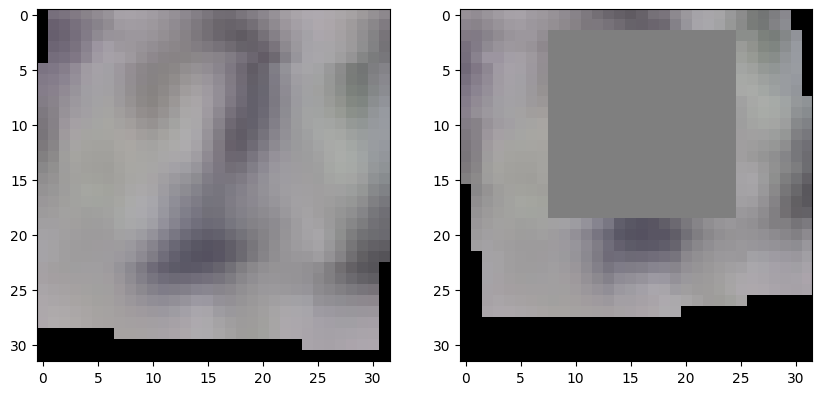

In [22]:
dst_X_weak, dst_X_strong = next(iter(train_unlabeled_dl))
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
mean_tensor = torch.tensor(0.5).unsqueeze(0).unsqueeze(0)
std_tensor = torch.tensor(0.5).unsqueeze(0).unsqueeze(0)
idx = 30
axes[0].imshow(
    dst_X_weak.permute(0, 2, 3, 1)[idx] * std_tensor +  mean_tensor
)
axes[1].imshow(
    dst_X_strong.permute(0, 2, 3, 1)[idx] * std_tensor +  mean_tensor
)
plt.show()

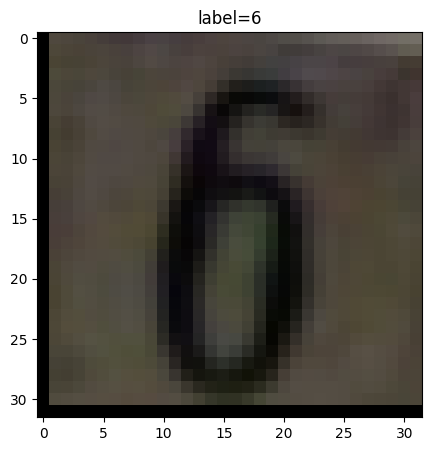

In [30]:
dst_X_weak_labeled, dst_labels = next(iter(train_labeled_dl))
fig, ax = plt.subplots(figsize=(5, 5))
mean_tensor = torch.tensor(0.5).unsqueeze(0).unsqueeze(0)
std_tensor = torch.tensor(0.5).unsqueeze(0).unsqueeze(0)
idx = 0
ax.imshow(
    dst_X_weak_labeled.permute(0, 2, 3, 1)[idx] * std_tensor +  mean_tensor
)
ax.set_title(f'label={dst_labels[idx]}')
plt.show()